In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

# **1. Import Libraries**

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import datetime
import os
import skimage.io
import random
import cv2
# from keras.preprocessing import image

print(tf.__version__)
print(f"numpy Version: {np.version.version}")

2.4.1
numpy Version: 1.19.5


# **2. Model Generation - MobileNet v2**

In [3]:
# base model with MobileNetV2
IMAGE_SIZE = 64
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

learning_rate = 1e-6
model = tf.keras.Sequential([base_model,
                           maxpool_layer,
                           prediction_layer])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# **3. Dataset Generator**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/My\ Drive/Colab\ Notebooks


/content/drive/My Drive/Colab Notebooks


In [6]:
!unzip train.zip -d data
!unzip val.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/val/Crack/CIP Test 057_44_6.jpg  
  inflating: data/val/Crack/CIP Test 057_44_7.jpg  
  inflating: data/val/Crack/CIP Test 057_44_8.jpg  
  inflating: data/val/Crack/CIP Test 057_44_9.jpg  
  inflating: data/val/Crack/CIP Test 057_45_0.jpg  
  inflating: data/val/Crack/CIP Test 057_45_1.jpg  
  inflating: data/val/Crack/CIP Test 057_45_2.jpg  
  inflating: data/val/Crack/CIP Test 057_45_3.jpg  
  inflating: data/val/Crack/CIP Test 057_45_4.jpg  
  inflating: data/val/Crack/CIP Test 057_45_5.jpg  
  inflating: data/val/Crack/CIP Test 057_45_6.jpg  
  inflating: data/val/Crack/CIP Test 057_45_7.jpg  
  inflating: data/val/Crack/CIP Test 057_45_8.jpg  
  inflating: data/val/Crack/CIP Test 057_46_0.jpg  
  inflating: data/val/Crack/CIP Test 057_47_0.jpg  
  inflating: data/val/Crack/CIP Test 057_48_1.jpg  
  inflating: data/val/Crack/CIP Test 057_48_10.jpg  
  inflating: data/val/Crack/CIP Test 057_48_11.jpg  
  inflating

In [7]:
os.getcwd() 


'/content/drive/My Drive/Colab Notebooks'

In [8]:
BATCH_SIZE = 256
IMG_HEIGHT= 64
IMG_WIDTH = 64
STEPS_PER_EPOCH = 100

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255., 
                                                                  rotation_range=20,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2) #substract normalization value

# data_dir="C:/Users/kwon/Mobile_Mask_RCNN/data/deficiency/train"
data_dir="/content/drive/My Drive/Colab Notebooks/data/train"
train_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(np.array(['BG','Crack'])))
# data_dir="C:/Users/kwon/Mobile_Mask_RCNN/data/deficiency/val"
data_dir="/content/drive/My Drive/Colab Notebooks/data/val"
val_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(np.array(['BG','Crack']))) #augmentation - rotation, shift-padding option padding - valid


Found 131008 images belonging to 2 classes.
Found 23975 images belonging to 2 classes.


# **4. Train**

In [9]:
history = model.fit(train_data_gen,
                    epochs=15,
                    validation_data=val_data_gen)

Epoch 1/15
512/512 [==============================] - 349s 665ms/step - loss: 0.8301 - accuracy: 0.5454 - val_loss: 0.7799 - val_accuracy: 0.5770
Epoch 2/15
512/512 [==============================] - 336s 657ms/step - loss: 0.8006 - accuracy: 0.5636 - val_loss: 0.7522 - val_accuracy: 0.5950
Epoch 3/15
512/512 [==============================] - 339s 663ms/step - loss: 0.7738 - accuracy: 0.5815 - val_loss: 0.7293 - val_accuracy: 0.6099
Epoch 4/15
512/512 [==============================] - 337s 658ms/step - loss: 0.7468 - accuracy: 0.6032 - val_loss: 0.7033 - val_accuracy: 0.6353
Epoch 5/15
512/512 [==============================] - 337s 659ms/step - loss: 0.7296 - accuracy: 0.6196 - val_loss: 0.6842 - val_accuracy: 0.6504
Epoch 6/15
512/512 [==============================] - 337s 658ms/step - loss: 0.7058 - accuracy: 0.6371 - val_loss: 0.6653 - val_accuracy: 0.6669
Epoch 7/15
512/512 [==============================] - 337s 658ms/step - loss: 0.6858 - accuracy: 0.6573 - val_loss: 0.6422 -

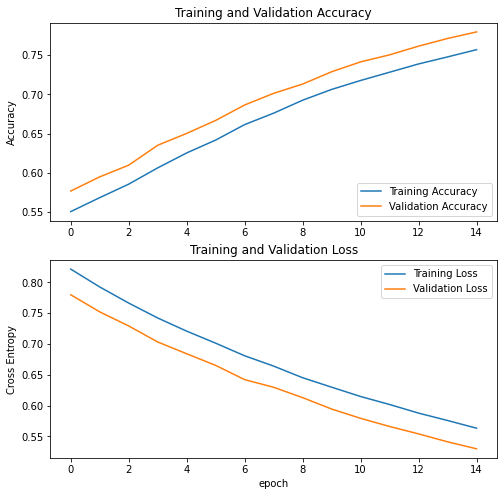

In [10]:
model.save_weights('weights_before_fine_tune.h5')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



# **5. Fine-Tuning**

In [11]:
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:100]:
  layer.trainable = False

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,864,002
Non-trainable params: 396,544
_________________________________________________________________


In [13]:
fine_tune_epochs = 30
total_epochs =  15 + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=30,
                         validation_data=val_data_gen)

Epoch 1/30
512/512 [==============================] - 343s 665ms/step - loss: 0.8576 - accuracy: 0.6399 - val_loss: 0.5726 - val_accuracy: 0.7748
Epoch 2/30
512/512 [==============================] - 341s 665ms/step - loss: 0.4844 - accuracy: 0.8222 - val_loss: 0.3846 - val_accuracy: 0.8908
Epoch 3/30
512/512 [==============================] - 363s 710ms/step - loss: 0.3622 - accuracy: 0.8777 - val_loss: 0.2566 - val_accuracy: 0.9252
Epoch 4/30
512/512 [==============================] - 339s 663ms/step - loss: 0.2974 - accuracy: 0.9019 - val_loss: 0.2007 - val_accuracy: 0.9411
Epoch 5/30
512/512 [==============================] - 339s 663ms/step - loss: 0.2579 - accuracy: 0.9163 - val_loss: 0.1721 - val_accuracy: 0.9487
Epoch 6/30
512/512 [==============================] - 339s 662ms/step - loss: 0.2315 - accuracy: 0.9228 - val_loss: 0.1552 - val_accuracy: 0.9519
Epoch 7/30
512/512 [==============================] - 341s 665ms/step - loss: 0.2121 - accuracy: 0.9298 - val_loss: 0.1448 -

In [14]:
model.save_weights('weights_after_finetuned.h5')

In [4]:
model.save('finetuned.h5')

NameError: ignored

In [1]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

NameError: ignored

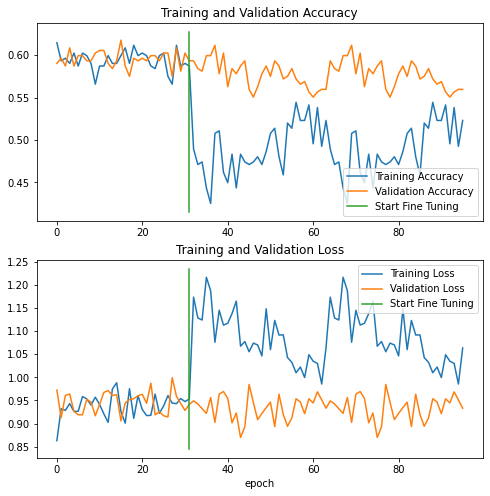

In [ ]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([32-1,32-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([32-1,32-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **6. Inference model**

In [7]:
reconstructed_model = tf.keras.models.load_model("finetuned.h5")

In [ ]:
sgd = tf.keras.optimizers.SGD(lr=1e-6)
reconstructed_model.compile(optimizer='sgd', loss="categorical_crossentropy")
reconstructed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,864,002
Non-trainable params: 396,544
_________________________________________________________________


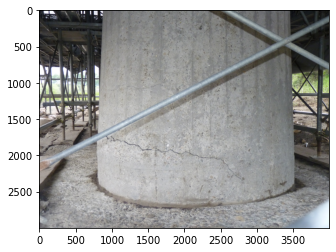

In [15]:
image = skimage.io.imread(os.path.join('/content/drive/My Drive/Colab Notebooks/data/test', 'P1040451.jpg'))
from skimage.transform import resize
# image=skimage.transform.resize(image,(1500,1500))
plt.imshow(image)
plt.show()

93 125


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


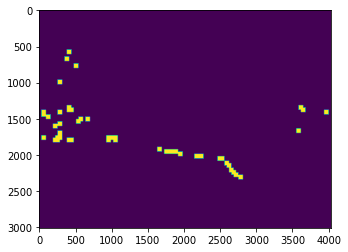

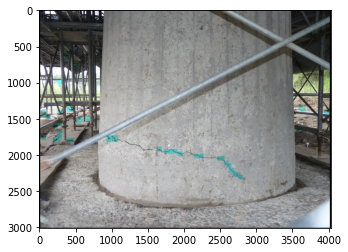

In [16]:
# h1, w1, h2, w2 = [ 78 ,  284 ,  3402 ,  1820 ]
# h1, w1, h2, w2 = [ 0 ,  341 ,  3648 ,  1941 ]

oh, ow = image.shape[:2]

scale = max(1, 64 / min(oh, ow))
max_h, max_w = oh, ow

# Height - image
if oh % 64 > 0:
    max_h = oh - (oh % 64) + 64
    top_pad = (max_h - oh) // 2
    bottom_pad = max_h - oh - top_pad
else:
    top_pad = bottom_pad = 0
    
# Width - image
if ow % 64 > 0:
    max_w = ow - (ow % 64) + 64
    left_pad = (max_w - ow) // 2
    right_pad = max_w - ow - left_pad
else:
    left_pad = right_pad = 0
        
padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
image = np.pad(image, padding, mode='constant', constant_values=0)
new_map = np.full((max_h*max_w), 0).reshape(max_h, max_w)

m, n = round((max_h - 64)/32) + 1, round((max_w - 64)/32) + 1
print(m ,n)
patch_size = 32    
for j in range(n-1):
    for i in range(m-1):
        from skimage.transform import resize
        new_h1, new_h2 = (patch_size*i), (patch_size*(i)+64)
        new_w1, new_w2 = (patch_size*j), (patch_size*(j)+64)
        new_image = image[new_h1 : new_h2, new_w1 : new_w2] # 64 patch
        
        # plt.imshow(new_image)
        # plt.show()
        # print(new_image.shape)
        # x = image.img_to_array(new_img)
        x = np.expand_dims(new_image, axis=0) / 255.0
        images = x
        # print(images.shape)
        classes = reconstructed_model.predict_classes(images)
        if classes[0] == 1: #and (new_h1 >= h1 and new_h2 <= h2) and (new_w1 >= w1 and new_w2 <= w2): #BG = not display
            new_map[new_h1 : new_h2, new_w1 : new_w2] = 1
plt.imshow(new_map)
plt.show()
image[:,:,0] = np.where(new_map[:,:] == 1, image[:,:,0]*(1-0.5) + 0.5*255*255, image[:,:,0])
plt.imshow(image)
plt.show()



In [17]:
# new_filename = "result_literature12" + ".jpg"
# dest_dir = "/content/drive/My Drive/Colab Notebooks/result/result"
cv2.imwrite('/content/drive/My Drive/Colab Notebooks/result4.jpg', image)

True